# Text Classification with an RNN
https://www.tensorflow.org/text/tutorials/text_classification_rnn
https://towardsdatascience.com/text-classification-using-word-embeddings-and-deep-learning-in-python-classifying-tweets-from-6fe644fcfc81

In [2]:
import pandas as pd
import numpy as np
import os
from datetime import date
from text_preprocessing import TextToTensor
import tensorflow as tf

2022-10-16 14:27:07.550520: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

## 1. Setup input pipeline

### 1.1. Stop words

In [4]:
stop_words = []
try:
    stop_words = pd.read_csv('./data/stop_words.txt', header=None)[0].tolist()
except Exception as e:
    print(f'Bad stop_words.txt file: {e}')

### 1.2. The datasets

In [5]:
train = pd.read_csv('./data/train.csv')[['text', 'target']]
test = pd.read_csv('./data/test.csv')

In [12]:
type(train.iloc[1])

pandas.core.series.Series

In [13]:
for example in [train.iloc[1]]:
    print(f'text: {example[0]}')
    print(f'label: {example[1]}')

text: Forest fire near La Ronge Sask. Canada
label: 1


In [14]:
train.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [15]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


### 1.3. Shuffle the data for the k-fold analysis

In [16]:
train = train.sample(frac=1)

In [17]:
train.head()

,text,target
3999,Typhoon Soudelor approaches after 7 killed 2 m...,1
5904,Watch This Airport Get Swallowed Up By A Sands...,1
2362,7 Christians detained in Zhejiang amid widespr...,0
6242,Can you list 5 reasons why a London #TubeStrik...,0
6165,u know the music good when you hear the siren ...,0


In [18]:
for example in [train.iloc[1]]:
    print(f'text: {example[0]}')
    print(f'label: {example[1]}')

text: Watch This Airport Get Swallowed Up By A Sandstorm In Under A Minute http://t.co/8L4RFFZD0P
label: 1


### 1.4. Split train to X (texts) and y (labels)

In [19]:
X_train = train['text'].tolist()
y_train = train['target'].tolist()

X_test = test['text'].tolist()

In [20]:
X_train[:5]

['Typhoon Soudelor approaches after 7 killed 2 missing in floods in Philippines http://t.co/nJMiDySXoF via @abc7chicago',
 'Watch This Airport Get Swallowed Up By A Sandstorm In Under A Minute http://t.co/8L4RFFZD0P',
 '7 Christians detained in Zhejiang amid widespread anger over cross removal- over 1200 crosses removed since last yr http://t.co/8PICbkDJM0',
 'Can you list 5 reasons why a London #TubeStrike is better than a Snowstorm? Read here... http://t.co/PNaQXPrweg',
 'u know the music good when you hear the siren and you get chills']

In [21]:
y_train[:5]

[1, 1, 0, 0, 0]

In [22]:
X_test[:5]

['Just happened a terrible car crash',
 'Heard about #earthquake is different cities, stay safe everyone.',
 'there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all',
 'Apocalypse lighting. #Spokane #wildfires',
 'Typhoon Soudelor kills 28 in China and Taiwan']

In [46]:
# TODO: Clean the texts

## 2. Create the text encoder
The raw text needs to be processed before it can be used in a model. 

Here we TextVectorization will be used to create the layer.

Create the encoder layer and pass the dataset's text to the layer's .adapt method

In [37]:
VOCAB_SIZE = 5000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(X_train)

The .adapt method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokers they're sorted by frequency:

In [38]:
vocabs = np.array(encoder.get_vocabulary())

In [42]:
vocabs[:20]

array(['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is', 'for',
       'on', 'you', 'my', 'with', 'it', 'that', 'at', 'by', 'this'],
      dtype='<U29')

In [41]:
vocabs[4980:5001]

array(['shaker', 'sewer', 'settle', 'setlist', 'server', 'serve',
       'servants', 'sequel', 'sept', 'sep', 'selling', 'sell',
       'selection', 'seduction', 'seal', 'scwx', 'scuf', 'screw',
       'screamqueens', 'scream'], dtype='<U29')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless we set a fixed ouput_sequence_length)

In [48]:
X_train[:3]

['Typhoon Soudelor approaches after 7 killed 2 missing in floods in Philippines http://t.co/nJMiDySXoF via @abc7chicago',
 'Watch This Airport Get Swallowed Up By A Sandstorm In Under A Minute http://t.co/8L4RFFZD0P',
 '7 Christians detained in Zhejiang amid widespread anger over cross removal- over 1200 crosses removed since last yr http://t.co/8PICbkDJM0']

In [47]:
encoded_example = encoder(X_train)[:3].numpy()
encoded_example

array([[ 509,  740, 2357,   38,  679,  115,   72,  301,    4,  210,    4,
        1292,    1,   51,    1,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [ 134,   19,  587,   48,  656,   28,   18,    3,  396,    4,  213,
           3,  572,    1,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [ 679, 2756, 4226,    4,    1,  761, 3503, 4457,   64,  266, 3764,
          64, 3477, 4261,    1,  229,  137, 2376,    1,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0]])

Let's try to reverse the encoded example to its original texts.

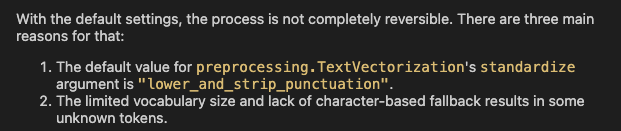

In [50]:
print(f"Original: {X_train[0]}")
round_trip = " ".join(vocabs[encoded_example[0]])
print(f"Round-trip: {round_trip}")
print()

Original: Typhoon Soudelor approaches after 7 killed 2 missing in floods in Philippines http://t.co/nJMiDySXoF via @abc7chicago
Round-trip: typhoon soudelor approaches after 7 killed 2 missing in floods in philippines [UNK] via [UNK]                



## 3. Create the model
### 3.1. Define the RNN model
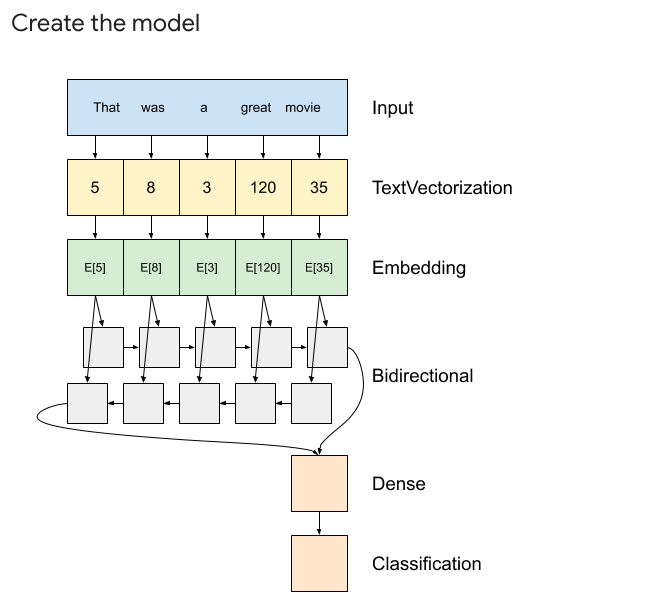

- The model will be build as a tf.keras.Sequential
- The input layer passes in the raw texts
- The first layer is the *encoder* that converts the text to a sequence to token indices.
- The second layer is an *embedding layer*. This layer stores one vector per word. 
    - When called, it converts the sequences of word indices to sequences of vectors.
    - These vectors are trainable. After training, words with similar meanings often have similar vectors.
- A RNN processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.
    - tf.keras.layers.Bidirectional wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output.
    - Main adv: the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.
    - Main disadv: we can't efficiently stream predictions as words are being added to the end
- After the RNN has converted the sequence to a single vector, the 2 layers.Dense do some final processing, and convert from this vector representation to a single logit as the classification output.

Source: https://www.tensorflow.org/text/tutorials/text_classification_rnn

In [53]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense

Keras sequential model is used here since all the layers in the model only have single input and produce single output.

To use stateful RNN layer, build the model with Keras functional API or model subclassing so that RNN layer states can be retrieved and reused.

Source: https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse

In [55]:
model = Sequential([
    encoder,
    Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # masking is used to handle the variable sequence lengths
        mask_zero=True
    ),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dense(1)
])

In [56]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_3 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 394,369
Trainable params: 394,369
Non-trai

In [57]:
# All the layers after Embedding layer support masking
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [60]:
# Predict sample_text
sample_text = 'There is an earthquake in Kuta Selatan Bali! Everybody was running outside!'
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 0s 60ms/step
[[0.00321409]]


In [62]:
# Predict on a sample text with padding
padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 222ms/step
[0.00321408]


The results were identical

### 3.2. Compile the model
To configure the training process

In [64]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

In [65]:
model.compile(loss = BinaryCrossentropy(from_logits=True),
             optimizer = Adam(1e-4),
             metrics=['accuracy'])

### 3.3. Train the model
https://www.tensorflow.org/api_docs/python/tf/keras/Sequential

In [66]:
history = model.fit(X_train,y_train,epochs=10)

Epoch 1/10
238/238 [==============================] - 21s 41ms/step - loss: 0.6775 - accuracy: 0.5703
Epoch 2/10
238/238 [==============================] - 8s 32ms/step - loss: 0.4977 - accuracy: 0.7558
Epoch 3/10
238/238 [==============================] - 8s 33ms/step - loss: 0.3878 - accuracy: 0.8336
Epoch 4/10
238/238 [==============================] - 8s 35ms/step - loss: 0.3314 - accuracy: 0.8623
Epoch 5/10
238/238 [==============================] - 8s 33ms/step - loss: 0.2944 - accuracy: 0.8785
Epoch 6/10
238/238 [==============================] - 8s 35ms/step - loss: 0.2613 - accuracy: 0.8944
Epoch 7/10
238/238 [==============================] - 8s 33ms/step - loss: 0.2305 - accuracy: 0.9099
Epoch 8/10
238/238 [==============================] - 8s 33ms/step - loss: 0.2114 - accuracy: 0.9186
Epoch 9/10
238/238 [==============================] - 8s 32ms/step - loss: 0.1900 - accuracy: 0.9254
Epoch 10/10
238/238 [==============================] - 8s 32ms/step - loss: 0.1765 - accur

### 3.4. Predictions

In [85]:
def transformPredictions(preds):
    """
    Function to normalize and 
    transform pred to 1 or 0 based on the threshold: 0
    Args:
    - unnormalized preds: array like
    """
    norm = np.linalg.norm(preds)
    normal_array = preds/norm
    
    transformed_yhat = []
    for i in normal_array:
        if i >= 0:
            transformed_yhat.append(1)
        else:
            transformed_yhat.append(0)
    
    return transformed_yhat

In [89]:
# Using sample_text
# sample_text = 'There is an earthquake in Kuta Selatan Bali! Everybody was running outside!'
predictions = model.predict(np.array([sample_text]))
print(transformPredictions(predictions))

1/1 [==============================] - 0s 44ms/step
[1]


In [73]:
# Using the test_set - unlabeled
predictions1 = model.predict(np.array(X_test))

102/102 [==============================] - 1s 10ms/step


In [86]:
transformed_yhat = transformPredictions(predictions1)

In [90]:
preds = {'Text': X_test, 'Prediction': transformed_yhat}
preds = pd.DataFrame(preds)

In [96]:
preds.to_csv('./data/predictions_test.csv')

In [94]:
preds[:20]

,Text,Prediction
0,Just happened a terrible car crash,1
1,"Heard about #earthquake is different cities, s...",1
2,"there is a forest fire at spot pond, geese are...",1
3,Apocalypse lighting. #Spokane #wildfires,1
4,Typhoon Soudelor kills 28 in China and Taiwan,1
5,We're shaking...It's an earthquake,1
6,They'd probably still show more life than Arse...,0
7,Hey! How are you?,0
8,What a nice hat?,0
9,Fuck off!,0


In [97]:
# Evaluate using the training set - labeled
# Find another disaster tweets dataset - labeled
train_loss, train_acc = model.evaluate(X_train,y_train)
print(f"Test loss: {train_loss}")
print(f"Test accuracy: {train_acc}")

238/238 [==============================] - 6s 9ms/step - loss: 0.1466 - accuracy: 0.9431
Test loss: 0.1465991586446762
Test accuracy: 0.9431235790252686


**Save the model**

https://www.tensorflow.org/tutorials/keras/save_and_load

In [100]:
# Save the model
model.save('./model/RNNDisasterClf')

INFO:tensorflow:Assets written to: ./model/RNNDisasterClf/assets


INFO:tensorflow:Assets written to: ./model/RNNDisasterClf/assets


In [101]:
from tensorflow.keras.models import load_model
# Load the model
loaded_model = load_model('./model/RNNDisasterClf')

# Check its architecture
loaded_model.summary()

2022-10-16 16:24:35.634581: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-10-16 16:24:35.656088: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-10-16 16:24:36.743404: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-10-16 16:24:37.969072: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-10-16 16:24:38.671070: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_sh

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_3 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 394,369
Trainable params: 394,369
Non-trai

In [102]:
# Predict using loaded model
sample_texts2 = ['There is an earthquake in Kuta Selatan Bali! Everybody was running outside!', 'RUN!', 'Hmmm, I am so hungry']
predictions2 = model.predict(np.array(sample_texts2))
print(transformPredictions(predictions2))

1/1 [==============================] - 0s 29ms/step
[1, 0, 0]
